
# Optimizers from scratch

In this notebook you'll implement several first-order optimizers

* Stochastic Gradient Descent (SGD)
* SGD with Momentum
* RMSProp
* Adam

and visualize their optimization trajectories on a simple 2D loss surface.


In [115]:

import numpy as np
import matplotlib.pyplot as plt

from visualization import plot_contours, plot_trajectory, visualize_optimization

%matplotlib inline



## 1. Toy 2D loss function

We'll use a simple quadratic function with elongated, rotated level sets.
This makes it easy to see how different optimizers behave.


In [116]:

def quad_function(theta, a=1.0, b=0.5, c=3.0):
    """
    Elliptical quadratic: 0.5 * (a x^2 + 2 b x y + c y^2).

    `theta` can be shape (2,) or (..., 2).
    """
    x, y = theta[..., 0], theta[..., 1]
    return 0.5 * (a * x**2 + 2.0 * b * x * y + c * y**2)


def quad_grad(theta, a=1.0, b=0.5, c=3.0):
    """Gradient of `quad_function` at a single point theta (shape (2,))."""
    x, y = theta[0], theta[1]
    grad_x = a * x + b * y
    grad_y = b * x + c * y
    return np.array([grad_x, grad_y])


## Alternative: More challenging loss functions

The quadratic function above is simple but doesn't show off optimizer differences well.
Below are more challenging functions that better highlight how different optimizers behave.


In [117]:
# Rosenbrock function - classic optimization benchmark with narrow curved valley
# Global minimum at (1, 1), but hard to optimize due to narrow valley
def rosenbrock_function(theta, a=1.0, b=100.0):
    """
    Rosenbrock function: (a - x)^2 + b * (y - x^2)^2
    
    Has a narrow curved valley leading to the global minimum at (a, a^2) = (1, 1).
    Very challenging for first-order optimizers.
    
    `theta` can be shape (2,) or (..., 2).
    """
    x, y = theta[..., 0], theta[..., 1]
    return (a - x)**2 + b * (y - x**2)**2


def rosenbrock_grad(theta, a=1.0, b=100.0):
    """Gradient of Rosenbrock function at a single point theta (shape (2,))."""
    x, y = theta[0], theta[1]
    grad_x = -2 * (a - x) - 4 * b * x * (y - x**2)
    grad_y = 2 * b * (y - x**2)
    return np.array([grad_x, grad_y])


# Function with multiple local minima and a saddle point
def challenging_function(theta):
    """
    A challenging function with:
    - Multiple local minima
    - A saddle point
    - Different curvature in different directions
    
    Global minimum near (0, 0) but with many local minima around it.
    `theta` can be shape (2,) or (..., 2).
    """
    x, y = theta[..., 0], theta[..., 1]
    # Combination of terms creating multiple local minima
    term1 = 0.5 * (x**2 + y**2)  # Bowl shape
    term2 = 2.0 * np.sin(2 * x) * np.sin(2 * y)  # Oscillatory component
    term3 = 0.1 * (x**4 + y**4)  # Higher order terms
    return term1 + term2 + term3


def challenging_grad(theta):
    """Gradient of challenging_function at a single point theta (shape (2,))."""
    x, y = theta[0], theta[1]
    grad_x = x + 4.0 * np.cos(2 * x) * np.sin(2 * y) + 0.4 * x**3
    grad_y = y + 4.0 * np.sin(2 * x) * np.cos(2 * y) + 0.4 * y**3
    return np.array([grad_x, grad_y])


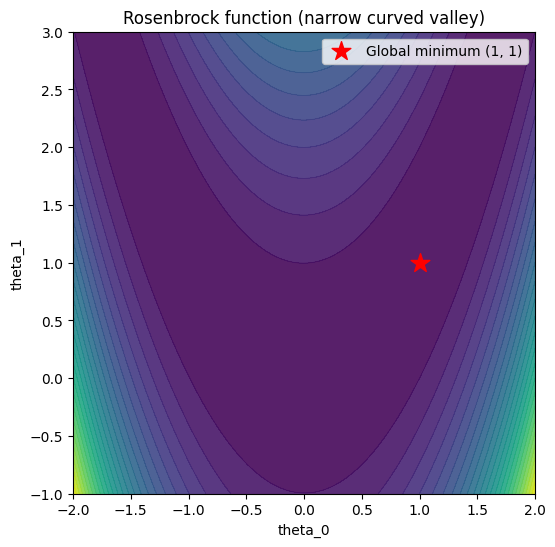

In [118]:
# Visualize the Rosenbrock function
x_range = (-2.0, 2.0)
y_range = (-1.0, 3.0)

fig, ax = plt.subplots(figsize=(6, 6))
plot_contours(ax, rosenbrock_function, x_range=x_range, y_range=y_range, levels=30)
ax.set_title("Rosenbrock function (narrow curved valley)")
ax.scatter([1], [1], marker='*', s=200, color='red', label='Global minimum (1, 1)')
ax.legend()
plt.show()


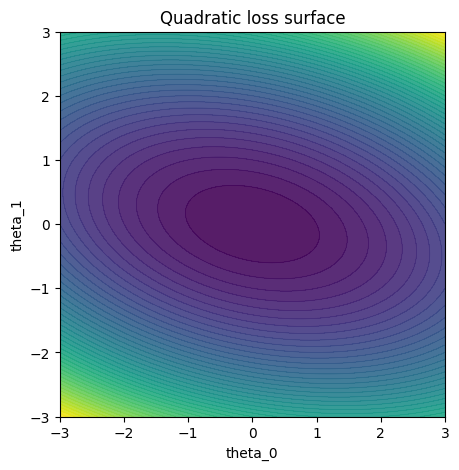

In [119]:

# Plot the loss surface
x_range = (-3.0, 3.0)
y_range = (-3.0, 3.0)

fig, ax = plt.subplots(figsize=(5, 5))
plot_contours(ax, quad_function, x_range=x_range, y_range=y_range)
ax.set_title("Quadratic loss surface")
plt.show()



## 2. Generic optimization loop

We'll write a small helper that runs an optimizer given a *step function*.

Your step functions will all have the same signature:

```python
new_theta, new_state = step_fn(theta, grad, state, t, **hyperparams)
```

* `theta` is the current parameter vector (shape `(2,)`).
* `grad` is the gradient at `theta`.
* `state` is a dictionary where you can store optimizer-specific state
  such as momentum or moving averages.
* `t` is the current step number starting from 1.


In [120]:

def run_optimizer(step_fn, theta0, num_iters, grad_fn=quad_grad, loss_fn=None, noise_scale=0.0, 
                  lr_schedule=None, **step_kwargs):
    """Run an optimizer and record the full trajectory and loss history.

    Parameters
    ----------
    step_fn : callable
        Function of the form `theta, state = step_fn(theta, grad, state, t, **kwargs)`.
    theta0 : array-like, shape (2,)
        Initial point.
    num_iters : int
        Number of optimization steps.
    grad_fn : callable, default=quad_grad
        Function that computes the gradient at a point theta (shape (2,)).
    loss_fn : callable, optional
        Function that computes the loss at a point theta. If None, loss history is not tracked.
    noise_scale : float, default=0.0
        Standard deviation of Gaussian noise to add to gradients (simulates stochasticity).
    lr_schedule : callable, optional
        Learning rate schedule function that takes iteration t and returns learning rate.
        If provided, overrides the 'lr' in step_kwargs.
    **step_kwargs :
        Extra hyperparameters for `step_fn` (e.g. learning rate).

    Returns
    -------
    trajectory : ndarray, shape (num_iters + 1, 2)
        All visited parameter vectors including the starting point.
    loss_history : ndarray, shape (num_iters + 1,), optional
        Loss values at each iteration. Only returned if loss_fn is provided.
    """
    theta = np.array(theta0, dtype=float)
    trajectory = [theta.copy()]
    loss_history = []
    state = {}

    # Record initial loss if loss function is provided
    if loss_fn is not None:
        loss_history.append(loss_fn(theta))

    for t in range(1, num_iters + 1):
        grad = grad_fn(theta)
        # Add noise to simulate stochastic gradients
        if noise_scale > 0:
            grad = grad + noise_scale * np.random.randn(*grad.shape)
        
        # Apply learning rate schedule if provided
        if lr_schedule is not None:
            current_lr = lr_schedule(t)
            step_kwargs_with_lr = {**step_kwargs, 'lr': current_lr}
        else:
            step_kwargs_with_lr = step_kwargs
            
        theta, state = step_fn(theta, grad, state, t, **step_kwargs_with_lr)
        trajectory.append(theta.copy())
        
        # Record loss if loss function is provided
        if loss_fn is not None:
            loss_history.append(loss_fn(theta))

    result = np.stack(trajectory, axis=0)
    if loss_fn is not None:
        return result, np.array(loss_history)
    return result



## 3. SGD

**Update rule**

\begin{align}
\theta_{t+1} = \theta_t - \eta \, \nabla_\theta L(\theta_t)
\end{align}

Implement the SGD step function below.


In [121]:

def sgd_step(theta, grad, state, t, lr=0.1):
    """Plain stochastic gradient descent.

    Parameters
    ----------
    theta : ndarray, shape (2,)
    grad : ndarray, shape (2,)
    state : dict (unused, but kept for API compatibility)
    t : int
    lr : float
        Learning rate.
    """
    new_theta = theta - lr * grad
    return new_theta, state


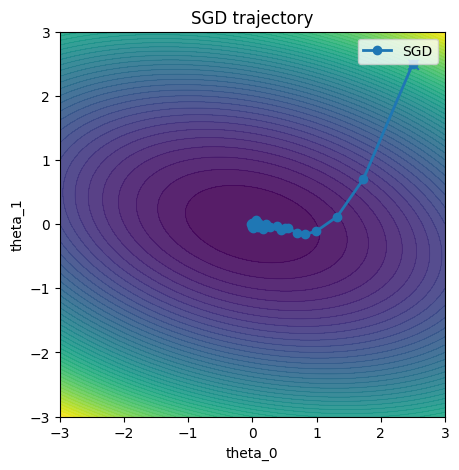

In [122]:

theta0 = np.array([2.5, 2.5])
num_iters = 50

sgd_traj = run_optimizer(sgd_step, theta0, num_iters, noise_scale = 0.15, lr=0.2)

fig, ax = plt.subplots(figsize=(5, 5))
plot_contours(ax, quad_function, x_range=x_range, y_range=y_range)
plot_trajectory(ax, sgd_traj, label="SGD")
ax.legend()
ax.set_title("SGD trajectory")
plt.show()



## 4. SGD with Momentum

**Update rule** (one common variant):

\begin{align}
v_t &= \beta v_{t-1} + (1 - \beta) \nabla_\theta L(\theta_t) \\
\theta_{t+1} &= \theta_t - \eta v_t
\end{align}

We'll store the velocity vector `v` inside the `state` dictionary.


In [123]:

def momentum_step(theta, grad, state, t, lr=0.1, beta=0.9):
    """SGD with momentum.

    State dict fields:
    * state["v"] : velocity vector, same shape as theta
    """
    if "v" not in state:
        state["v"] = np.zeros_like(theta)

    v = state["v"]

    v = beta * v + (1 - beta) * grad
    theta = theta - lr * v
    state["v"] = v
    return theta, state


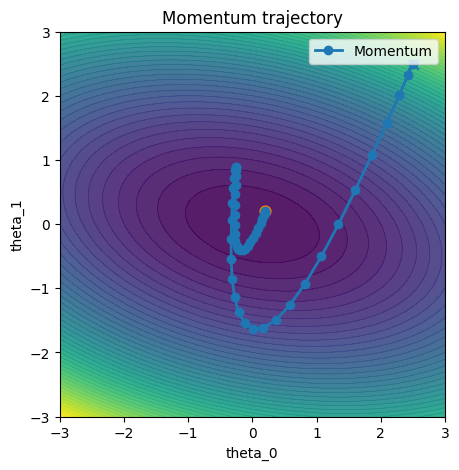

In [124]:

# Visualize momentum once you've implemented it.
theta0 = np.array([2.5, 2.5])
num_iters = 50

momentum_traj = run_optimizer(momentum_step, theta0, num_iters, noise_scale = 0.15, lr=0.2, beta=0.9)

fig, ax = plt.subplots(figsize=(5, 5))
plot_contours(ax, quad_function, x_range=x_range, y_range=y_range)
plot_trajectory(ax, momentum_traj, label="Momentum")
ax.legend()
ax.set_title("Momentum trajectory")
plt.show()



## 5. RMSProp

RMSProp keeps a moving average of squared gradients and divides the learning
rate by the root of this average.

**Update rule**

\begin{align}
s_t &= \rho s_{t-1} + (1 - \rho) \, g_t^2 \\
\theta_{t+1} &= \theta_t - \frac{\eta}{\sqrt{s_t} + \epsilon} g_t
\end{align}


In [125]:

def rmsprop_step(theta, grad, state, t, lr=0.01, rho=0.9, eps=1e-8):
    """RMSProp optimizer step.

    State dict fields:
    * state["s"] : running average of squared gradients
    """
    if "s" not in state:
        state["s"] = np.zeros_like(theta)

    s = state["s"]

    s2 = rho * s + (1 - rho) * (grad ** 2) 
    theta2 = theta - lr * grad / (s2 ** 0.5 + eps)
    state["s"] = s2

    return theta2, state


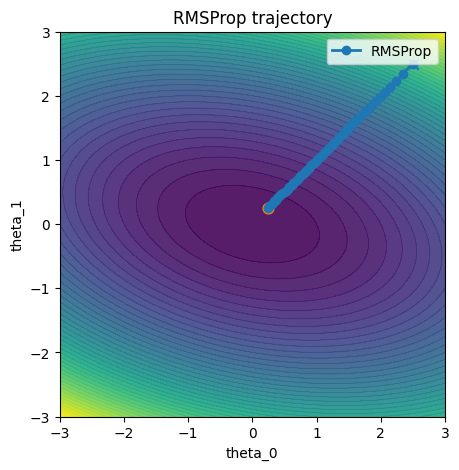

In [126]:

# Visualize RMSProp once you've implemented it.
theta0 = np.array([2.5, 2.5])
num_iters = 50

rmsprop_traj = run_optimizer(rmsprop_step, theta0, num_iters, noise_scale = 0.15, lr=0.05, rho=0.9, eps=1e-8)

fig, ax = plt.subplots(figsize=(5, 5))
plot_contours(ax, quad_function, x_range=x_range, y_range=y_range)
plot_trajectory(ax, rmsprop_traj, label="RMSProp")
ax.legend()
ax.set_title("RMSProp trajectory")
plt.show()



## 6. Adam

Adam combines momentum and RMSProp-style adaptivity and includes bias
correction terms.

**Update rule**

\begin{align}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat m_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat v_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_{t+1} &= \theta_t - \eta \frac{\hat m_t}{\sqrt{\hat v_t} + \epsilon}
\end{align}


In [127]:

def adam_step(theta, grad, state, t, lr=0.01,
              beta1=0.9, beta2=0.999, eps=1e-8):
    """Adam optimizer step with bias correction.

    State dict fields:
    * state["m"] : first moment (mean of gradients)
    * state["v"] : second moment (mean of squared gradients)
    """
    if "m" not in state:
        state["m"] = np.zeros_like(theta)
    if "v" not in state:
        state["v"] = np.zeros_like(theta)

    m = state["m"]
    v = state["v"]

    momentum = beta1 * m + (1 - beta1) * grad
    velocity = beta2 * v + (1 - beta2) * grad ** 2
    scaled_momentum = momentum / (1 - beta1)
    scaled_velocity = velocity / (1 - beta2)

    theta2 = theta - lr * scaled_momentum / (scaled_velocity ** 0.5 + eps)

    state["m"] = momentum
    state["v"] = velocity

    return theta2, state

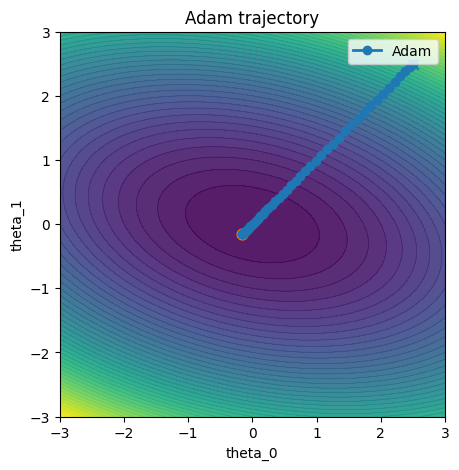

In [128]:

# Visualize Adam once you've implemented it.
theta0 = np.array([2.5, 2.5])
num_iters = 50

adam_traj = run_optimizer(adam_step, theta0, num_iters,
                          lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8)

fig, ax = plt.subplots(figsize=(5, 5))
plot_contours(ax, quad_function, x_range=x_range, y_range=y_range)
plot_trajectory(ax, adam_traj, label="Adam")
ax.legend()
ax.set_title("Adam trajectory")
plt.show()



## 7. Compare all optimizers

Once you've implemented all four optimizers above and run their respective
cells to create `sgd_traj`, `momentum_traj`, `rmsprop_traj`, and `adam_traj`,
you can overlay them on the same loss surface.


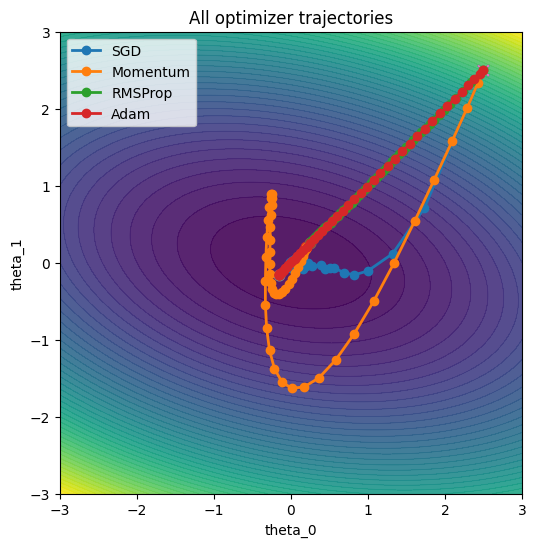

In [129]:

# Make sure you've run the earlier cells so that the *_traj variables exist.
trajectories = {
    "SGD": sgd_traj,
    "Momentum": momentum_traj,
    "RMSProp": rmsprop_traj,
    "Adam": adam_traj,
}

fig, ax = plt.subplots(figsize=(6, 6))
plot_contours(ax, quad_function, x_range=x_range, y_range=y_range)
for name, traj in trajectories.items():
    plot_trajectory(ax, traj, label=name)
ax.legend()
ax.set_title("All optimizer trajectories")
plt.show()


## 8. Compare optimizers on challenging functions

Let's see how different optimizers perform on the Rosenbrock function, which has a narrow curved valley that makes optimization challenging.


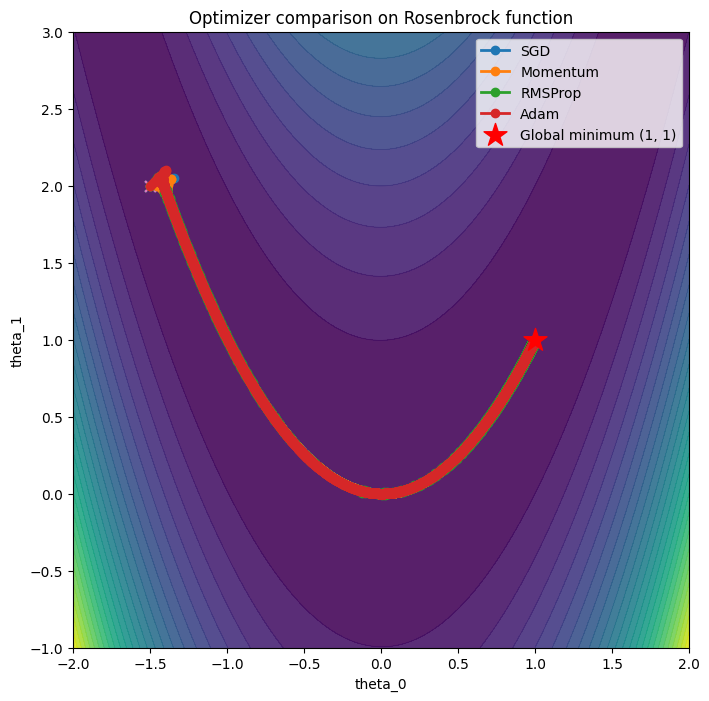

Final function values:
SGD: 0.006405
Momentum: 0.006289
RMSProp: 0.023614
Adam: 0.000019


In [130]:
# Compare all optimizers on Rosenbrock function
# Start from a point that requires navigating the narrow valley
theta0 = np.array([-1.5, 2.0])
num_iters = 5000  # More iterations needed for challenging function
noise_scale = 0.15
x_range = (-2.0, 2.0)
y_range = (-1.0, 3.0)

# Run all optimizers with appropriate learning rates for Rosenbrock
# Add noise to simulate stochastic gradients
noise_scale = 0.1

np.random.seed(42)
sgd_traj_rosen, sgd_loss_rosen = run_optimizer(sgd_step, theta0, num_iters, 
                                grad_fn=rosenbrock_grad, loss_fn=rosenbrock_function, 
                                noise_scale=noise_scale, lr=0.001)

np.random.seed(42)
momentum_traj_rosen, momentum_loss_rosen = run_optimizer(momentum_step, theta0, num_iters,
                                     grad_fn=rosenbrock_grad, loss_fn=rosenbrock_function,
                                     noise_scale=noise_scale, lr=0.001, beta=0.9)

np.random.seed(42)
rmsprop_traj_rosen, rmsprop_loss_rosen = run_optimizer(rmsprop_step, theta0, num_iters,
                                    grad_fn=rosenbrock_grad, loss_fn=rosenbrock_function,
                                    noise_scale=noise_scale, lr=0.01, rho=0.9, eps=1e-8)

np.random.seed(42)
adam_traj_rosen, adam_loss_rosen = run_optimizer(adam_step, theta0, num_iters,
                                 grad_fn=rosenbrock_grad, loss_fn=rosenbrock_function,
                                 noise_scale=noise_scale, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8)

# Plot all trajectories
fig, ax = plt.subplots(figsize=(8, 8))
plot_contours(ax, rosenbrock_function, x_range=x_range, y_range=y_range, levels=30)
plot_trajectory(ax, sgd_traj_rosen, label="SGD", linewidth=2)
plot_trajectory(ax, momentum_traj_rosen, label="Momentum", linewidth=2)
plot_trajectory(ax, rmsprop_traj_rosen, label="RMSProp", linewidth=2)
plot_trajectory(ax, adam_traj_rosen, label="Adam", linewidth=2)
ax.scatter([1], [1], marker='*', s=300, color='red', zorder=10, label='Global minimum (1, 1)')
ax.legend()
ax.set_title("Optimizer comparison on Rosenbrock function")
plt.show()

# Print final values
print("Final function values:")
print(f"SGD: {rosenbrock_function(sgd_traj_rosen[-1]):.6f}")
print(f"Momentum: {rosenbrock_function(momentum_traj_rosen[-1]):.6f}")
print(f"RMSProp: {rosenbrock_function(rmsprop_traj_rosen[-1]):.6f}")
print(f"Adam: {rosenbrock_function(adam_traj_rosen[-1]):.6f}")


### Convergence plots: Loss vs Iterations

Let's see how quickly each optimizer converges by plotting loss over iterations:


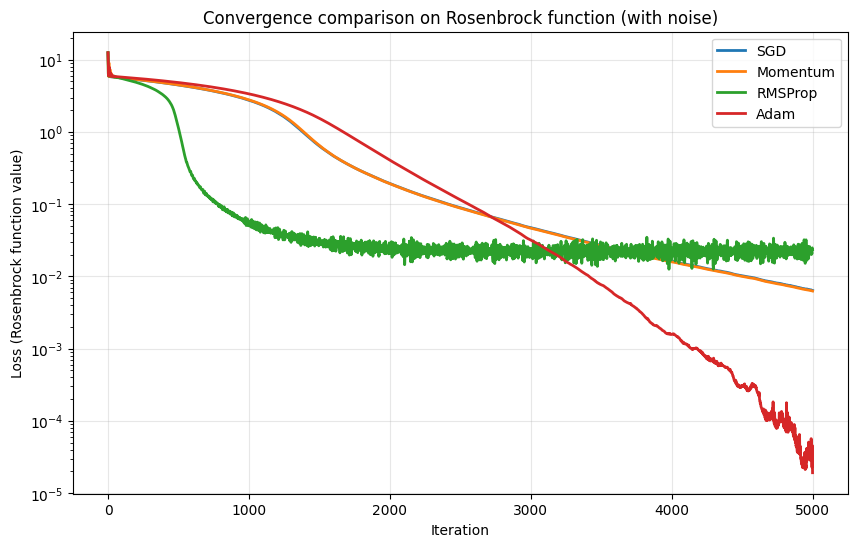

Iterations to converge (loss < 1e-3):
SGD: Did not converge within 5000 iterations (final: 0.006405)
Momentum: Did not converge within 5000 iterations (final: 0.006289)
RMSProp: Did not converge within 5000 iterations (final: 0.023614)
Adam: 4142 iterations


In [131]:
# Plot convergence curves for Rosenbrock function
fig, ax = plt.subplots(figsize=(10, 6))
iterations = np.arange(len(sgd_loss_rosen))

ax.plot(iterations, sgd_loss_rosen, label="SGD", linewidth=2)
ax.plot(iterations, momentum_loss_rosen, label="Momentum", linewidth=2)
ax.plot(iterations, rmsprop_loss_rosen, label="RMSProp", linewidth=2)
ax.plot(iterations, adam_loss_rosen, label="Adam", linewidth=2)

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss (Rosenbrock function value)")
ax.set_title("Convergence comparison on Rosenbrock function (with noise)")
ax.set_yscale("log")  # Use log scale to better see convergence
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Print convergence statistics
convergence_threshold = 1e-3
print("Iterations to converge (loss < 1e-3):")
for name, loss_history in [("SGD", sgd_loss_rosen), ("Momentum", momentum_loss_rosen), 
                            ("RMSProp", rmsprop_loss_rosen), ("Adam", adam_loss_rosen)]:
    converged = np.where(loss_history < convergence_threshold)[0]
    if len(converged) > 0:
        print(f"{name}: {converged[0]} iterations")
    else:
        print(f"{name}: Did not converge within {num_iters} iterations (final: {loss_history[-1]:.6f})")


## 10. Learning Rate Schedules

The loss plot for RMSprop is a typically symptom of a constant learning rate. When it gets closer to the equilibrium, the learning rate is too high and the loss begins to oscillate too much.

In [138]:
# Learning rate schedule functions
def constant_schedule(initial_lr):
    """Constant learning rate (no schedule)."""
    return lambda t: initial_lr

def step_schedule(initial_lr, decay_factor=0.5, step_size=1000):
    """Step decay: reduce LR by decay_factor every step_size iterations."""
    def schedule(t):
        return initial_lr * (decay_factor ** (t // step_size))
    return schedule

def exponential_schedule(initial_lr, decay_rate=0.001):
    """Exponential decay: lr = initial_lr * exp(-decay_rate * t)."""
    return lambda t: initial_lr * np.exp(-decay_rate * t)

def polynomial_schedule(initial_lr, power=0.5, max_iter=10000):
    """Polynomial decay: lr = initial_lr * (1 - t/max_iter)^power."""
    return lambda t: initial_lr * ((1 - min(t, max_iter) / max_iter) ** power)

def cosine_schedule(initial_lr, min_lr=0.0, max_iter=10000):
    """Cosine annealing: lr = min_lr + (initial_lr - min_lr) * (1 + cos(π * t / max_iter)) / 2."""
    return lambda t: min_lr + (initial_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * min(t, max_iter) / max_iter))

def warm_restart_schedule(initial_lr, T_0=1000, T_mult=2, eta_min=0.0):
    """Cosine annealing with warm restarts."""
    def schedule(t):
        T_cur = T_0
        T_i = T_0
        i = 0
        while t >= T_cur:
            i += 1
            T_i = T_0 * (T_mult ** i)
            T_cur += T_i
        t_in_cycle = t - (T_cur - T_i)
        return eta_min + (initial_lr - eta_min) * 0.5 * (1 + np.cos(np.pi * t_in_cycle / T_i))
    return schedule


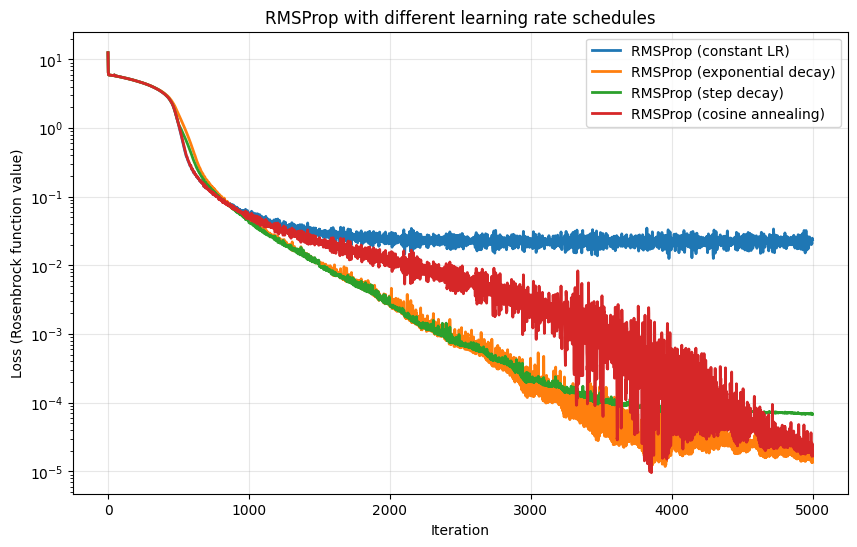

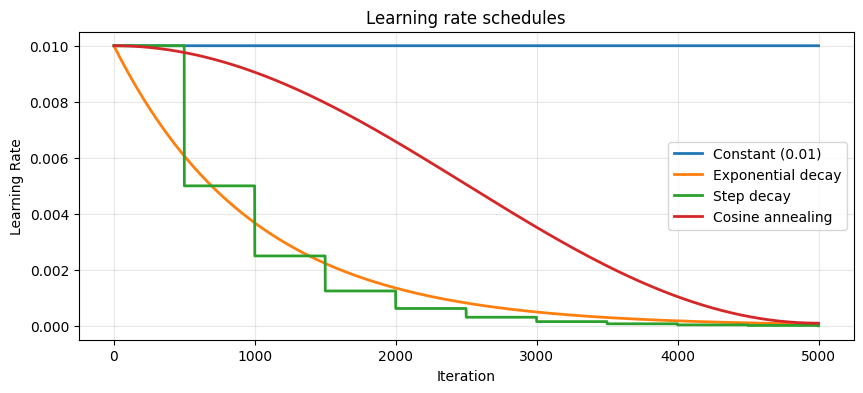

Final function values:
RMSProp (constant LR): 0.023614
RMSProp (exponential decay): 0.000014
RMSProp (step decay): 0.000068
RMSProp (cosine annealing): 0.000017


In [142]:
# Example: RMSProp with different learning rate schedules on Rosenbrock
theta0 = np.array([-1.5, 2.0])
num_iters = 5000
noise_scale = 0.1
x_range = (-2.0, 2.0)
y_range = (-1.0, 3.0)

# RMSProp with exponential decay schedule
lr_schedule_exp = exponential_schedule(initial_lr=0.01, decay_rate=0.001)
np.random.seed(42)
rmsprop_exp, rmsprop_loss_exp = run_optimizer(
    rmsprop_step, theta0, num_iters,
    grad_fn=rosenbrock_grad, loss_fn=rosenbrock_function,
    noise_scale=noise_scale, lr_schedule=lr_schedule_exp, rho=0.9, eps=1e-8
)

# RMSProp with constant learning rate
np.random.seed(42)
rmsprop_const, rmsprop_loss_const = run_optimizer(
    rmsprop_step, theta0, num_iters,
    grad_fn=rosenbrock_grad, loss_fn=rosenbrock_function,
    noise_scale=noise_scale, lr=0.01, rho=0.9, eps=1e-8
)

# RMSProp with step decay schedule
lr_schedule_step = step_schedule(initial_lr=0.01, decay_factor=0.5, step_size=500)
np.random.seed(42)
rmsprop_step_sched, rmsprop_loss_step = run_optimizer(
    rmsprop_step, theta0, num_iters,
    grad_fn=rosenbrock_grad, loss_fn=rosenbrock_function,
    noise_scale=noise_scale, lr_schedule=lr_schedule_step, rho=0.9, eps=1e-8
)

# RMSProp with cosine annealing schedule
lr_schedule_cosine = cosine_schedule(initial_lr=0.01, min_lr=0.0001, max_iter=num_iters)
np.random.seed(42)
rmsprop_cosine, rmsprop_loss_cosine = run_optimizer(
    rmsprop_step, theta0, num_iters,
    grad_fn=rosenbrock_grad, loss_fn=rosenbrock_function,
    noise_scale=noise_scale, lr_schedule=lr_schedule_cosine, rho=0.9, eps=1e-8
)

# Plot convergence comparison
fig, ax = plt.subplots(figsize=(10, 6))
iterations = np.arange(len(rmsprop_loss_const))

ax.plot(iterations, rmsprop_loss_const, label="RMSProp (constant LR)", linewidth=2)
ax.plot(iterations, rmsprop_loss_exp, label="RMSProp (exponential decay)", linewidth=2)
ax.plot(iterations, rmsprop_loss_step, label="RMSProp (step decay)", linewidth=2)
ax.plot(iterations, rmsprop_loss_cosine, label="RMSProp (cosine annealing)", linewidth=2)

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss (Rosenbrock function value)")
ax.set_title("RMSProp with different learning rate schedules")
ax.set_yscale("log")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Plot learning rate schedules
fig, ax = plt.subplots(figsize=(10, 4))
iterations_lr = np.arange(1, num_iters + 1)
ax.plot(iterations_lr, [0.01] * num_iters, label="Constant (0.01)", linewidth=2)
ax.plot(iterations_lr, [lr_schedule_exp(t) for t in iterations_lr], label="Exponential decay", linewidth=2)
ax.plot(iterations_lr, [lr_schedule_step(t) for t in iterations_lr], label="Step decay", linewidth=2)
ax.plot(iterations_lr, [lr_schedule_cosine(t) for t in iterations_lr], label="Cosine annealing", linewidth=2)
ax.set_xlabel("Iteration")
ax.set_ylabel("Learning Rate")
ax.set_title("Learning rate schedules")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("Final function values:")
print(f"RMSProp (constant LR): {rosenbrock_function(rmsprop_const[-1]):.6f}")
print(f"RMSProp (exponential decay): {rosenbrock_function(rmsprop_exp[-1]):.6f}")
print(f"RMSProp (step decay): {rosenbrock_function(rmsprop_step_sched[-1]):.6f}")
print(f"RMSProp (cosine annealing): {rosenbrock_function(rmsprop_cosine[-1]):.6f}")
